In [59]:
# Cell 1: Import Libraries
import os
import pandas as pd
import numpy as np
import boto3
from botocore.client import Config
from botocore.exceptions import ClientError
from io import BytesIO
from datetime import datetime

# IMPORTANT: Ensure pyarrow is installed for reading Parquet files
# If not, run: !pip install pyarrow
import pyarrow.parquet as pq

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [60]:
# Cell 2: Load MinIO Details from Environment Variables
# These MUST be set in your Windows environment before launching Jupyter
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT", 'http://localhost:9000')
MINIO_ACCESS_KEY = os.getenv("MINIO_ACCESS_KEY")
MINIO_SECRET_KEY = os.getenv("MINIO_SECRET_KEY")

# Basic validation (optional in notebook, but good for clarity)
if not MINIO_ACCESS_KEY or not MINIO_SECRET_KEY:
    print("Error: MinIO credentials not loaded. Please set environment variables.")
    # You might want to halt execution or load from a config file here for notebooks
else:
    print("MinIO credentials loaded successfully.")


MinIO credentials loaded successfully.


In [61]:
# Cell 3: Initialize MinIO S3 client
s3_client = None
try:
    s3_client = boto3.client(
        's3',
        endpoint_url=MINIO_ENDPOINT,
        aws_access_key_id=MINIO_ACCESS_KEY,
        aws_secret_access_key=MINIO_SECRET_KEY,
        config=Config(signature_version='s3v4'),
        region_name='us-east-1' # Placeholder region
    )
    s3_client.list_buckets() # Test connection
    print(f"MinIO S3 client initialized and connected to endpoint: {MINIO_ENDPOINT}")
except Exception as e:
    print(f"Error initializing or connecting to MinIO S3 client: {e}")
    print("Please ensure MinIO Docker container is running and accessible.")
    s3_client = None # Set to None if initialization fails


MinIO S3 client initialized and connected to endpoint: http://localhost:9000


In [62]:
# Cell 4: Helper Function to Read Processed Parquet Data for a Symbol
def load_processed_data_from_minio(bucket_name, data_type_prefix, symbol):
    if not s3_client:
        print("MinIO client not available, cannot load data.")
        return pd.DataFrame()

    all_dataframes = []
    # Construct the prefix to look for processed data for a specific symbol
    # Example: processed-financial-data/finnhub_quotes/AAPL/
    # Or: processed-financial-data/twelvedata_historical/AAPL/
    prefix = f"{data_type_prefix}/{symbol}/"

    try:
        paginator = s3_client.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

        for page in pages:
            if "Contents" in page:
                for obj in page['Contents']:
                    if obj['Key'].endswith('.parquet'):
                        try:
                            response = s3_client.get_object(Bucket=bucket_name, Key=obj['Key'])
                            parquet_data = response['Body'].read()
                            df = pd.read_parquet(BytesIO(parquet_data))
                            all_dataframes.append(df)
                        except Exception as e:
                            print(f"Error reading {obj['Key']} from MinIO: {e}")
        if all_dataframes:
            # Concatenate all dataframes and sort by the relevant timestamp/datetime column
            combined_df = pd.concat(all_dataframes, ignore_index=True)

            # Convert to datetime, force UTC, then localize to naive (no timezone info)
            if 'datetime' in combined_df.columns:
                combined_df['datetime'] = pd.to_datetime(combined_df['datetime'], utc=True, errors='coerce')
                combined_df['datetime'] = combined_df['datetime'].dt.tz_localize(None)
                combined_df = combined_df.sort_values(by='datetime').drop_duplicates(subset=['datetime']).set_index('datetime')
            elif 'timestamp' in combined_df.columns:
                combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], utc=True, errors='coerce')
                combined_df['timestamp'] = combined_df['timestamp'].dt.tz_localize(None)
                combined_df = combined_df.sort_values(by='timestamp').drop_duplicates(subset=['timestamp']).set_index('timestamp')

            return combined_df
        else:
            print(f"No processed data found for {symbol} under {data_type_prefix}.")
            return pd.DataFrame()
    except ClientError as e:
        print(f"MinIO Client Error when listing objects in s3://{bucket_name}/{prefix}: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"General error loading data for {symbol} from MinIO: {e}")
        return pd.DataFrame()

In [63]:
# Cell 5: Load and Inspect Finnhub Quotes for AAPL
processed_finnhub_quotes_df = load_processed_data_from_minio(
    bucket_name="processed-financial-data",
    data_type_prefix="finnhub_quotes",
    symbol="AAPL"
)

print("\nProcessed Finnhub Quotes for AAPL (first 5 rows):")
print(processed_finnhub_quotes_df.head())
print("\nProcessed Finnhub Quotes Info:")
processed_finnhub_quotes_df.info()


Processed Finnhub Quotes for AAPL (first 5 rows):
                             close    high    low    open  prev_close  spread  \
timestamp                                                                       
2025-06-16 09:55:48.589458  100.00  102.00   98.0   99.00        98.5    4.00   
2025-06-20 19:45:53.151821  100.00  102.00   98.0   99.00        98.5    4.00   
2025-06-21 00:12:27.147576  100.00  102.00   98.0   99.00        98.5    4.00   
NaT                         196.45  200.37  195.7  199.73       199.2    4.67   

                           symbol            fetch_timestamp  
timestamp                                                     
2025-06-16 09:55:48.589458   AAPL 2025-06-16 09:55:48.589462  
2025-06-20 19:45:53.151821   AAPL 2025-06-20 19:45:53.151825  
2025-06-21 00:12:27.147576   AAPL 2025-06-21 00:12:27.147580  
NaT                          AAPL 2025-06-15 02:43:19.408383  

Processed Finnhub Quotes Info:
                             close    high    low   

In [64]:
# Cell 6: Load and Inspect Twelve Data Historical for AAPL
processed_twelvedata_historical_df = load_processed_data_from_minio(
    bucket_name="processed-financial-data",
    data_type_prefix="twelvedata_historical",
    symbol="AAPL"
)

print("\nProcessed Twelve Data Historical for AAPL (first 5 rows):")
print(processed_twelvedata_historical_df.head())
print("\nProcessed Twelve Data Historical Info:")
processed_twelvedata_historical_df.info()



Processed Twelve Data Historical for AAPL (first 5 rows):
                  open        high     low      close     volume  \
datetime                                                           
2022-07-25  154.009995  155.039993  152.28  152.95000   53623900   
2022-07-26  152.259990  153.089996  150.80  151.60001   55138700   
2022-07-27  152.580000  157.330000  152.16  156.78999   78620700   
2022-07-28  156.980000  157.640000  154.41  157.35001   81378700   
2022-07-29  161.240010  163.630000  159.50  162.50999  101786900   

            daily_return symbol  
datetime                         
2022-07-25           NaN   AAPL  
2022-07-26     -0.008826   AAPL  
2022-07-27      0.034235   AAPL  
2022-07-28      0.003572   AAPL  
2022-07-29      0.032793   AAPL  

Processed Twelve Data Historical Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2022-07-25 to 2025-06-20
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        -

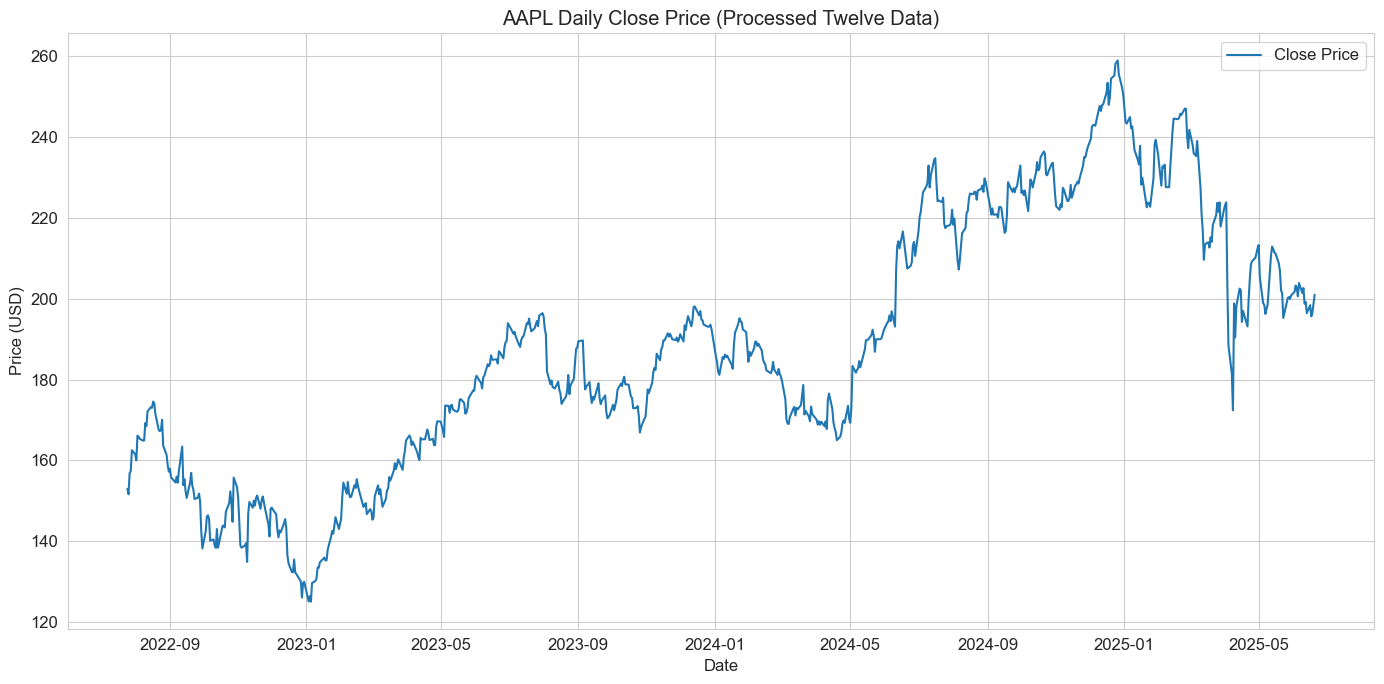

In [65]:
# Cell 7: Basic Visualization - Twelve Data Historical Close Price
if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    plt.figure(figsize=(14, 7))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['close'], label='Close Price')
    plt.title('AAPL Daily Close Price (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data to plot Twelve Data historical close price for AAPL.")

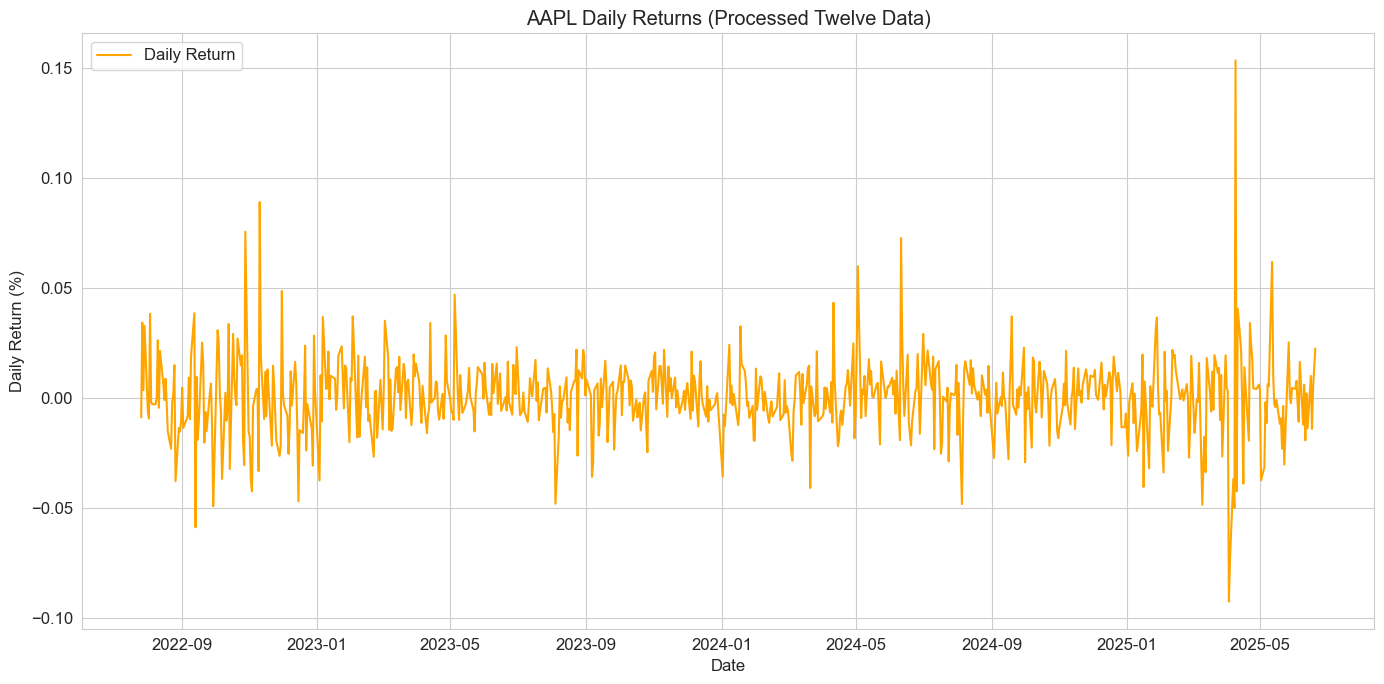

In [66]:
# Cell 8: Basic Visualization - Twelve Data Daily Returns
if not processed_twelvedata_historical_df.empty and 'daily_return' in processed_twelvedata_historical_df.columns:
    plt.figure(figsize=(14, 7))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['daily_return'], label='Daily Return', color='orange')
    plt.title('AAPL Daily Returns (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Daily Return (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data to plot Twelve Data daily returns for AAPL.")



Calculating Moving Averages for Twelve Data Historical (AAPL)...
Added SMA_20, SMA_50, and SMA_200 columns.
Last 5 rows with new SMA columns:
             close      SMA_20      SMA_50    SMA_200
datetime                                             
2025-06-13  196.45  201.897001  201.431201  224.45325
2025-06-16  198.42  201.255001  201.335801  224.30520
2025-06-17  195.64  200.598001  201.481001  224.15095
2025-06-18  196.58  200.084001  201.783401  223.98490
2025-06-20  201.00  200.029501  202.355001  223.84490
Added SMA_20, SMA_50, and SMA_200 columns.
Last 5 rows with new SMA columns:
             close      SMA_20      SMA_50    SMA_200
datetime                                             
2025-06-13  196.45  201.897001  201.431201  224.45325
2025-06-16  198.42  201.255001  201.335801  224.30520
2025-06-17  195.64  200.598001  201.481001  224.15095
2025-06-18  196.58  200.084001  201.783401  223.98490
2025-06-20  201.00  200.029501  202.355001  223.84490


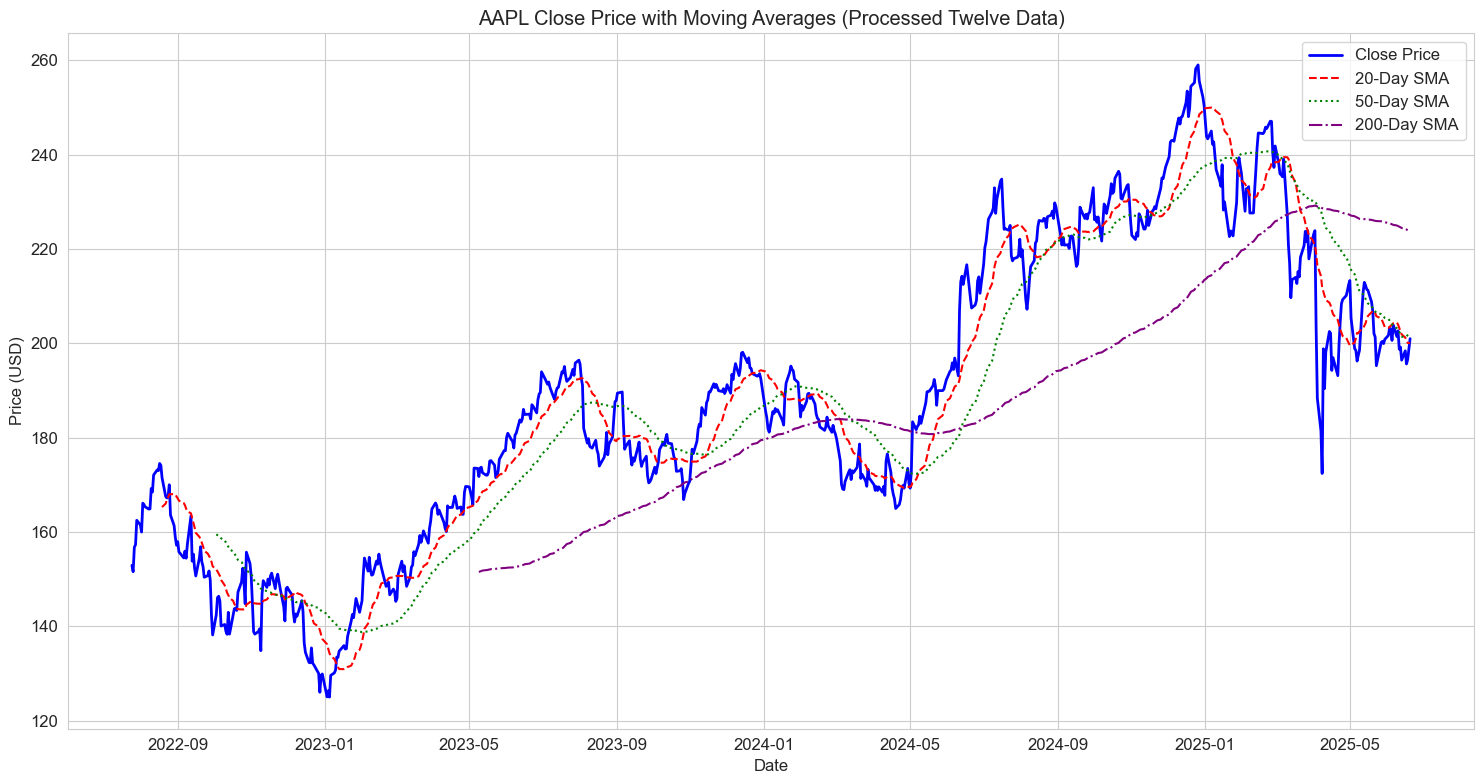

In [67]:
# Cell 9: Calculate and Plot Moving Averages
# Check if the DataFrame is not empty and has a 'close' column
if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    print("\nCalculating Moving Averages for Twelve Data Historical (AAPL)...")

    # --- Calculate Simple Moving Averages (SMA) ---
    # SMA 20-day: Often used for short-term trends
    processed_twelvedata_historical_df['SMA_20'] = processed_twelvedata_historical_df['close'].rolling(window=20).mean()

    # SMA 50-day: Often used for medium-term trends
    processed_twelvedata_historical_df['SMA_50'] = processed_twelvedata_historical_df['close'].rolling(window=50).mean()

    # SMA 200-day: Often used for long-term trends
    processed_twelvedata_historical_df['SMA_200'] = processed_twelvedata_historical_df['close'].rolling(window=200).mean()

    print("Added SMA_20, SMA_50, and SMA_200 columns.")
    print("Last 5 rows with new SMA columns:")
    print(processed_twelvedata_historical_df[['close', 'SMA_20', 'SMA_50', 'SMA_200']].tail())

    # --- Plotting Close Price with Moving Averages ---
    plt.figure(figsize=(15, 8))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['close'], label='Close Price', color='blue', linewidth=2)
    
    # Plot SMAs, only if they have enough data points (i.e., not NaN at the beginning)
    if 'SMA_20' in processed_twelvedata_historical_df.columns:
        plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_20'], label='20-Day SMA', color='red', linestyle='--')
    if 'SMA_50' in processed_twelvedata_historical_df.columns:
        plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_50'], label='50-Day SMA', color='green', linestyle=':')
    if 'SMA_200' in processed_twelvedata_historical_df.columns:
        plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_200'], label='200-Day SMA', color='purple', linestyle='-.')

    plt.title('AAPL Close Price with Moving Averages (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot Moving Averages. 'processed_twelvedata_historical_df' is empty or missing 'close' column.")




Calculating Relative Strength Index (RSI) for Twelve Data Historical (AAPL)...
Added RSI_14 column.
Last 5 rows with new RSI column:
             close     RSI_14
datetime                     
2025-06-13  196.45  40.721350
2025-06-16  198.42  44.171557
2025-06-17  195.64  40.581980
2025-06-18  196.58  42.289719
2025-06-20  201.00  49.621768
Added RSI_14 column.
Last 5 rows with new RSI column:
             close     RSI_14
datetime                     
2025-06-13  196.45  40.721350
2025-06-16  198.42  44.171557
2025-06-17  195.64  40.581980
2025-06-18  196.58  42.289719
2025-06-20  201.00  49.621768


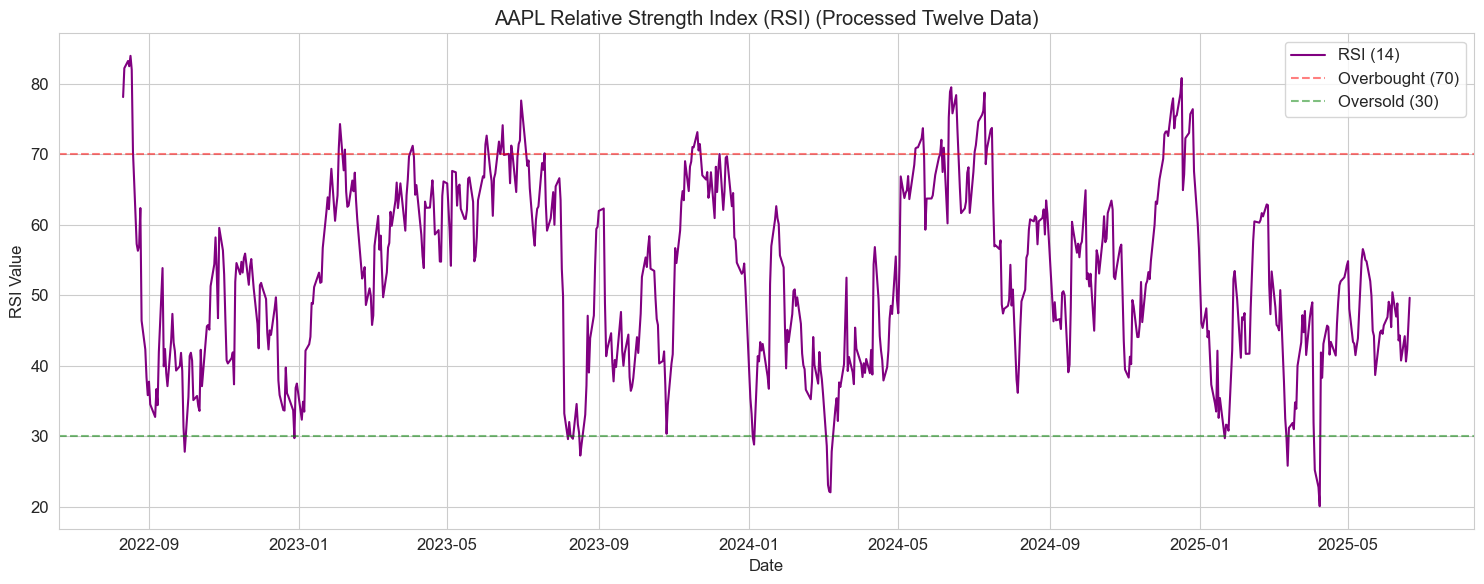

In [68]:
# Cell 10: Calculate and Plot Relative Strength Index (RSI)
# Function to calculate RSI
def calculate_rsi(df, window=14):
    """
    Calculates the Relative Strength Index (RSI) for a given DataFrame.
    Assumes 'close' price column is available.
    """
    if 'close' not in df.columns:
        return df # Return original DataFrame if close price is missing

    # Get the difference in price
    delta = df['close'].diff()

    # Get positive and negative gains
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate exponential moving average of gains and losses
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    df[f'RSI_{window}'] = rsi
    return df

# Check if the DataFrame is not empty and has a 'close' column
if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    print("\nCalculating Relative Strength Index (RSI) for Twelve Data Historical (AAPL)...")

    # Calculate RSI with a typical window of 14 days
    processed_twelvedata_historical_df = calculate_rsi(processed_twelvedata_historical_df, window=14)

    print("Added RSI_14 column.")
    print("Last 5 rows with new RSI column:")
    print(processed_twelvedata_historical_df[['close', 'RSI_14']].tail())

    # --- Plotting RSI ---
    plt.figure(figsize=(15, 6))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['RSI_14'], label='RSI (14)', color='purple', linewidth=1.5)
    
    # Add overbought and oversold lines
    plt.axhline(70, linestyle='--', alpha=0.5, color='red', label='Overbought (70)')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green', label='Oversold (30)')

    plt.title('AAPL Relative Strength Index (RSI) (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('RSI Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot RSI. 'processed_twelvedata_historical_df' is empty or missing 'close' column.")



Calculating MACD for Twelve Data Historical (AAPL)...
Added MACD_Line, MACD_Signal, and MACD_Histogram columns.
Last 5 rows with new MACD columns:
             close  MACD_Line  MACD_Signal  MACD_Histogram
datetime                                                  
2025-06-13  196.45  -1.609691    -1.279240       -0.330451
2025-06-16  198.42  -1.667807    -1.356953       -0.310854
2025-06-17  195.64  -1.916100    -1.468783       -0.447318
2025-06-18  196.58  -2.013810    -1.577788       -0.436022
2025-06-20  201.00  -1.714821    -1.605195       -0.109626


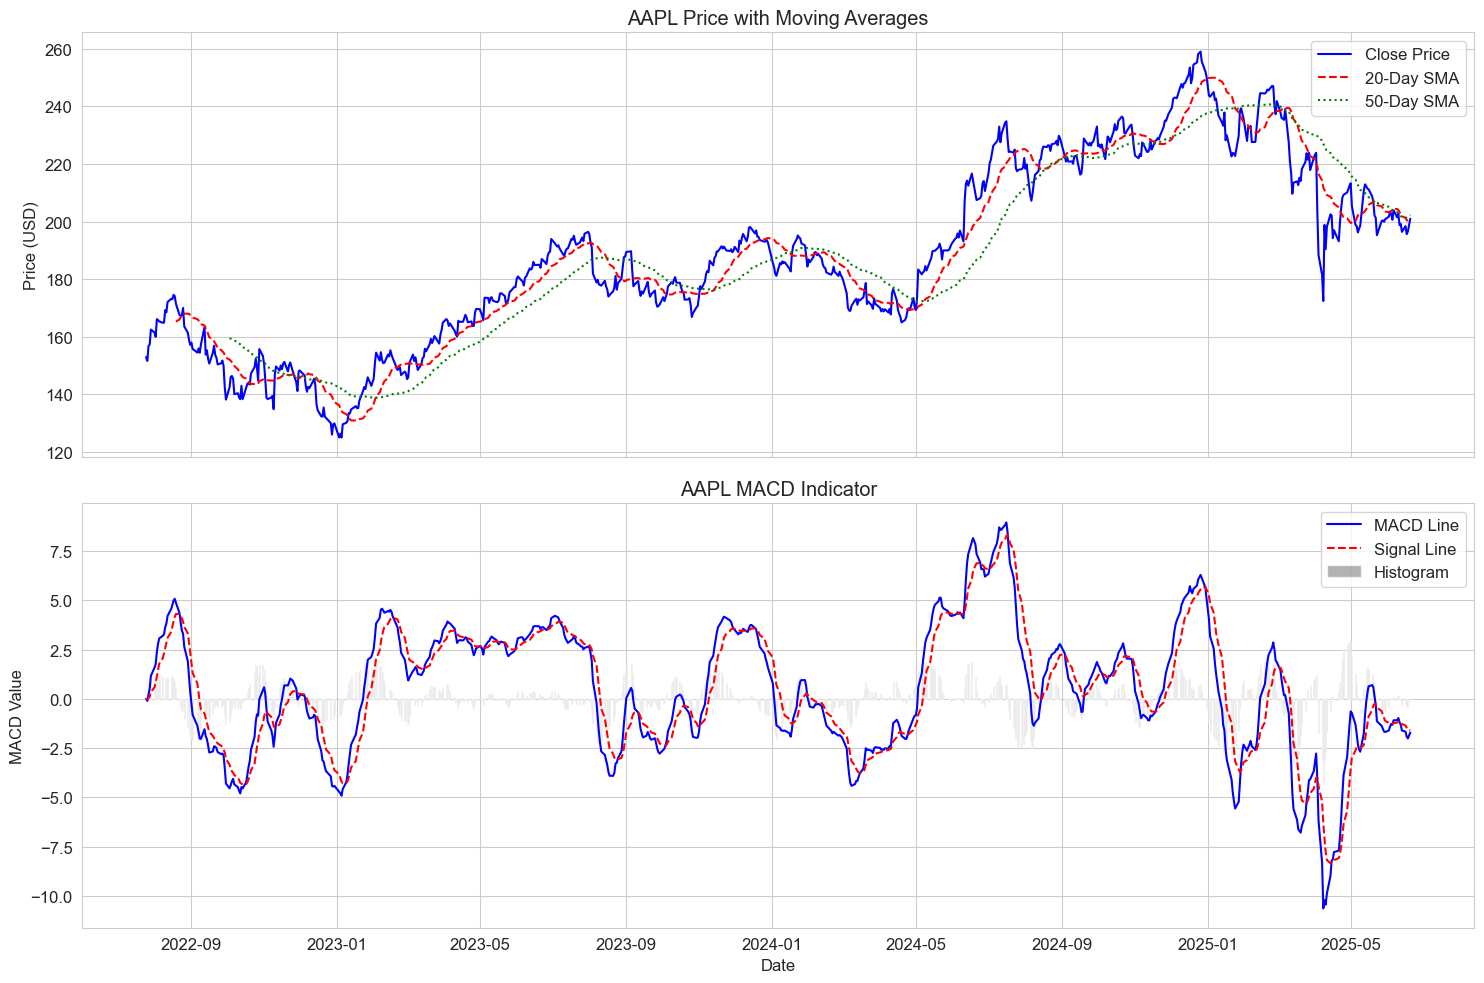

In [69]:
# Cell 11: Calculate and Plot Moving Average Convergence Divergence (MACD)
def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculates MACD (Moving Average Convergence Divergence) and Signal Line.
    Assumes 'close' price column is available.
    """
    if 'close' not in df.columns:
        return df # Return original DataFrame if close price is missing

    # Calculate the 12-period EMA
    ema_fast = df['close'].ewm(span=fast_period, adjust=False).mean()
    # Calculate the 26-period EMA
    ema_slow = df['close'].ewm(span=slow_period, adjust=False).mean()

    # Calculate MACD Line
    macd_line = ema_fast - ema_slow

    # Calculate the 9-period EMA of the MACD Line (Signal Line)
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD Histogram
    macd_histogram = macd_line - signal_line

    df[f'MACD_Line'] = macd_line
    df[f'MACD_Signal'] = signal_line
    df[f'MACD_Histogram'] = macd_histogram
    
    return df

if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    print("\nCalculating MACD for Twelve Data Historical (AAPL)...")

    processed_twelvedata_historical_df = calculate_macd(processed_twelvedata_historical_df)

    print("Added MACD_Line, MACD_Signal, and MACD_Histogram columns.")
    print("Last 5 rows with new MACD columns:")
    print(processed_twelvedata_historical_df[['close', 'MACD_Line', 'MACD_Signal', 'MACD_Histogram']].tail())

    # --- Plotting MACD ---
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True) # Two subplots for price and MACD
    
    # Plotting Price with Moving Averages (reusing earlier MA calculation if available)
    axes[0].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['close'], label='Close Price', color='blue', linewidth=1.5)
    if 'SMA_20' in processed_twelvedata_historical_df.columns:
        axes[0].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_20'], label='20-Day SMA', color='red', linestyle='--')
    if 'SMA_50' in processed_twelvedata_historical_df.columns:
        axes[0].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_50'], label='50-Day SMA', color='green', linestyle=':')
    axes[0].set_title('AAPL Price with Moving Averages')
    axes[0].set_ylabel('Price (USD)')
    axes[0].legend()
    axes[0].grid(True)

    # Plotting MACD
    axes[1].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['MACD_Line'], label='MACD Line', color='blue', linewidth=1.5)
    axes[1].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['MACD_Signal'], label='Signal Line', color='red', linestyle='--')
    
    # Plotting MACD Histogram
    axes[1].bar(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['MACD_Histogram'], label='Histogram', color='gray', alpha=0.6)

    axes[1].set_title('AAPL MACD Indicator')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('MACD Value')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot MACD. 'processed_twelvedata_historical_df' is empty or missing 'close' column.")




Calculating Bollinger Bands for Twelve Data Historical (AAPL)...
Added BB_Middle, BB_Upper, and BB_Lower columns.
Last 5 rows with new Bollinger Bands columns:
             close   BB_Middle    BB_Upper    BB_Lower
datetime                                              
2025-06-13  196.45  201.897001  209.433022  194.360979
2025-06-16  198.42  201.255001  207.511634  194.998369
2025-06-17  195.64  200.598001  206.258772  194.937230
2025-06-18  196.58  200.084001  205.190413  194.977590
2025-06-20  201.00  200.029501  205.068590  194.990413


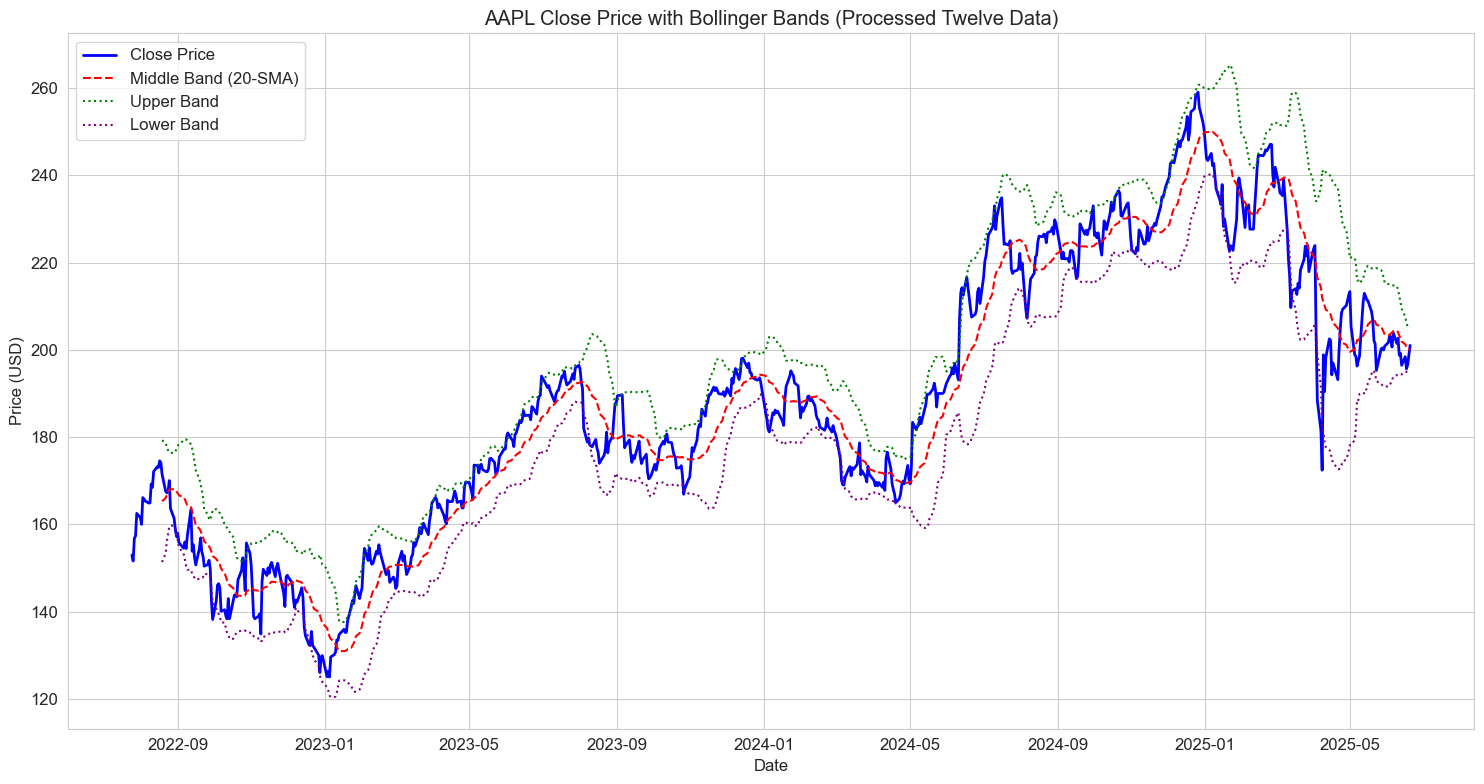

In [70]:
# Cell 12: Calculate and Plot Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    """
    Calculates Bollinger Bands (Middle Band, Upper Band, Lower Band).
    Assumes 'close' price column is available.
    """
    if 'close' not in df.columns:
        return df # Return original DataFrame if close price is missing

    # Middle Band is the N-period Simple Moving Average
    middle_band = df['close'].rolling(window=window).mean()
    # Standard deviation over N periods
    std_dev = df['close'].rolling(window=window).std()

    # Upper and Lower Bands
    upper_band = middle_band + (std_dev * num_std_dev)
    lower_band = middle_band - (std_dev * num_std_dev)

    df[f'BB_Middle'] = middle_band
    df[f'BB_Upper'] = upper_band
    df[f'BB_Lower'] = lower_band
    
    return df

if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    print("\nCalculating Bollinger Bands for Twelve Data Historical (AAPL)...")

    processed_twelvedata_historical_df = calculate_bollinger_bands(processed_twelvedata_historical_df)

    print("Added BB_Middle, BB_Upper, and BB_Lower columns.")
    print("Last 5 rows with new Bollinger Bands columns:")
    print(processed_twelvedata_historical_df[['close', 'BB_Middle', 'BB_Upper', 'BB_Lower']].tail())

    # --- Plotting Bollinger Bands ---
    plt.figure(figsize=(15, 8))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['close'], label='Close Price', color='blue', linewidth=2)
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['BB_Middle'], label='Middle Band (20-SMA)', color='red', linestyle='--')
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['BB_Upper'], label='Upper Band', color='green', linestyle=':')
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['BB_Lower'], label='Lower Band', color='purple', linestyle=':')

    plt.title('AAPL Close Price with Bollinger Bands (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot Bollinger Bands. 'processed_twelvedata_historical_df' is empty or missing 'close' column.")



In [71]:
# Cell 13: Example: Merge Finnhub Quotes with Twelve Data Historical (by date)
# This is a conceptual step if you want to combine data from both sources for analysis.
# Note: Finnhub quotes are usually real-time/intraday, TwelveData historical is typically end-of-day.
# Merging them directly might require careful time alignment and aggregation.

# For a simple demo, let's just show how you'd attempt a merge on date if they aligned.
# In a real scenario, you'd aggregate Finnhub data to daily before merging with daily historical.

if not processed_finnhub_quotes_df.empty and not processed_twelvedata_historical_df.empty:
    # Reset index to merge on date part of timestamp/datetime
    finnhub_daily = processed_finnhub_quotes_df.reset_index().set_index(processed_finnhub_quotes_df.index.normalize())
    twelvedata_daily = processed_twelvedata_historical_df.reset_index().set_index(processed_twelvedata_historical_df.index.normalize())

    # Select a few columns for the merged view
    merged_df = pd.merge(
        finnhub_daily[['close', 'high', 'low', 'open', 'symbol', 'spread']],
        twelvedata_daily[['close', 'volume', 'daily_return', 'symbol']].rename(columns={'close': 'td_close', 'volume': 'td_volume'}),
        left_index=True,
        right_index=True,
        how='inner',
        suffixes=('_finnhub', '_twelvedata')
    )
    print("\nExample of Merged Finnhub Quotes & Twelve Data Historical for AAPL (first 5 rows):")
    print(merged_df.head())
    print("\nMerged Data Info:")
    merged_df.info()
else:
    print("\nNot enough data to demonstrate merging Finnhub and Twelve Data for AAPL.")



Example of Merged Finnhub Quotes & Twelve Data Historical for AAPL (first 5 rows):
            close   high   low  open symbol_finnhub  spread  td_close  \
2025-06-16  100.0  102.0  98.0  99.0           AAPL     4.0    198.42   
2025-06-20  100.0  102.0  98.0  99.0           AAPL     4.0    201.00   

            td_volume  daily_return symbol_twelvedata  
2025-06-16   43020700      0.010028              AAPL  
2025-06-20   95914700      0.022484              AAPL  

Merged Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2 entries, 2025-06-16 to 2025-06-20
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   close              2 non-null      float64
 1   high               2 non-null      float64
 2   low                2 non-null      float64
 3   open               2 non-null      float64
 4   symbol_finnhub     2 non-null      object 
 5   spread             2 non-null      float64
 6 


Identifying simple trading signals for AAPL...
  SMA Crossover signals calculated (1=Buy, -1=Sell).
  RSI Overbought/Oversold signals calculated (1=Buy, -1=Sell, thresholds 40/60).
  Combined signals (AND) calculated (1=Buy, -1=Sell, thresholds 40/60).
  Combined_Signal_OR (OR logic) calculated (1=Buy, -1=Sell, thresholds 40/60).

Combined_Signal_OR value counts:
Combined_Signal_OR
 0    648
 1     46
-1     36
Name: count, dtype: int64

Last 10 rows with new signal columns:
             close      SMA_20      SMA_50     RSI_14  SMA_Crossover_Signal  \
datetime                                                                      
2025-06-06  203.92  204.271000  203.679401  50.405961                     1   
2025-06-09  201.45  204.417000  203.231401  46.959564                     0   
2025-06-10  202.67  204.011000  202.926801  48.820895                     0   
2025-06-11  198.78  203.303501  202.459801  43.570592                     0   
2025-06-12  199.20  202.647001  201.980001  4

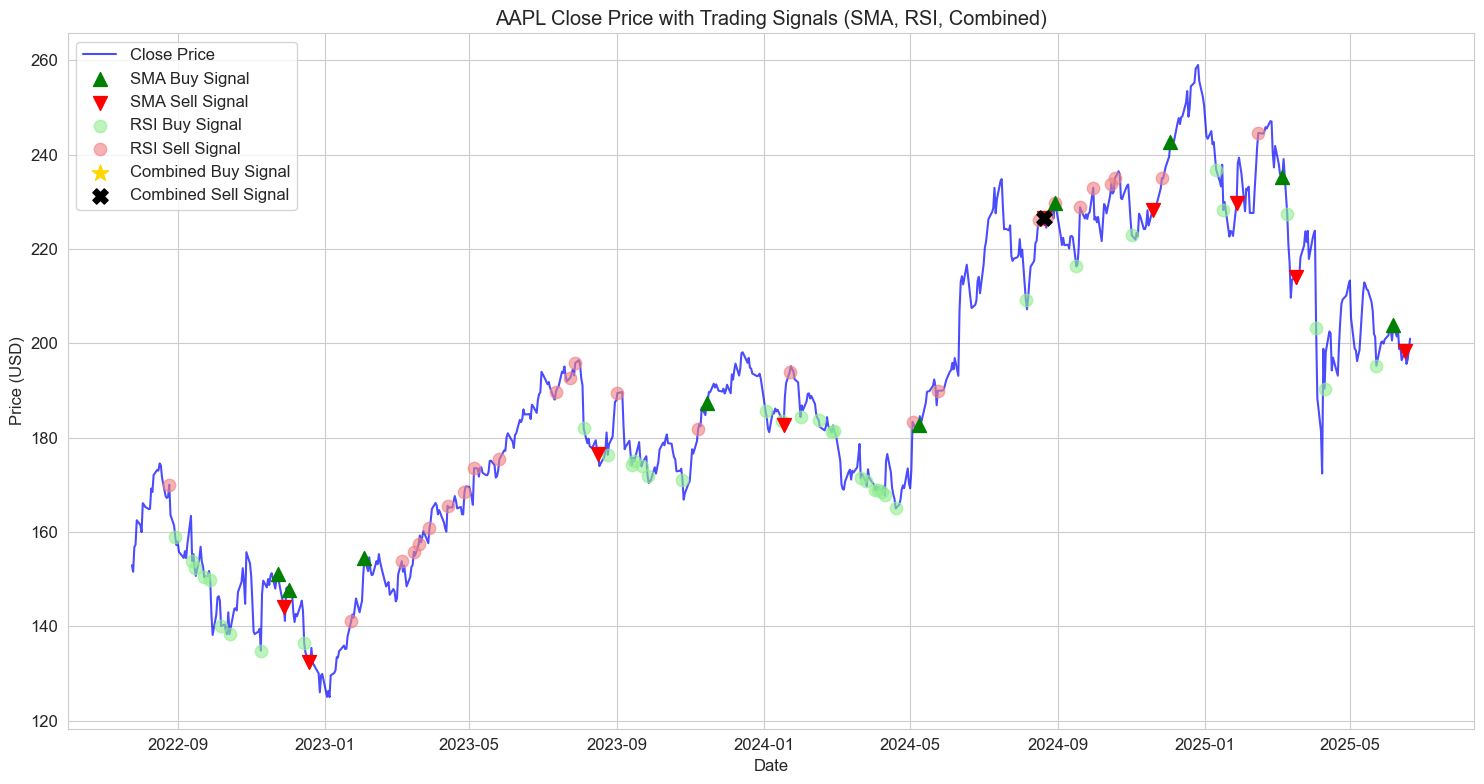

In [72]:
# Cell 14: Identify Simple Trading Signals (with Combined Signal)
# This cell uses the previously calculated indicators to generate basic buy/sell signals.
# This is a starting point; real trading strategies are far more complex.

if not processed_twelvedata_historical_df.empty:
    print("\nIdentifying simple trading signals for AAPL...")

    df_signals = processed_twelvedata_historical_df.copy() # Work on a copy to avoid SettingWithCopyWarning

    # --- SMA Crossover Signal ---
    # Buy when 20-day SMA crosses above 50-day SMA (bullish crossover)
    # Sell when 20-day SMA crosses below 50-day SMA (bearish crossover)
    df_signals['SMA_Crossover_Signal'] = 0 # Default to no signal
    if 'SMA_20' in df_signals.columns and 'SMA_50' in df_signals.columns:
        # Calculate the difference and its sign change
        df_signals['SMA_Diff'] = df_signals['SMA_20'] - df_signals['SMA_50']
        df_signals['SMA_Crossover'] = (df_signals['SMA_Diff'].shift(1) < 0) & (df_signals['SMA_Diff'] > 0) # Buy signal
        df_signals['SMA_Crossunder'] = (df_signals['SMA_Diff'].shift(1) > 0) & (df_signals['SMA_Diff'] < 0) # Sell signal
        df_signals.loc[df_signals['SMA_Crossover'], 'SMA_Crossover_Signal'] = 1 # Buy signal
        df_signals.loc[df_signals['SMA_Crossunder'], 'SMA_Crossover_Signal'] = -1 # Sell signal
        # Clean up temporary columns
        df_signals.drop(columns=['SMA_Diff', 'SMA_Crossover', 'SMA_Crossunder'], inplace=True)
        print("  SMA Crossover signals calculated (1=Buy, -1=Sell).")

    # --- RSI Overbought/Oversold Signal (looser: 40/60) ---
    # Buy when RSI crosses below Oversold (e.g., 30)
    # Sell when RSI crosses above Overbought (e.g., 70)
    df_signals['RSI_Signal'] = 0 # Default to no signal
    if 'RSI_14' in df_signals.columns:
        # Identify when RSI crosses below 40 (potential buy)
        df_signals['RSI_Buy_Cross'] = (df_signals['RSI_14'].shift(1) > 40) & (df_signals['RSI_14'] <= 40)
        # Identify when RSI crosses above 60 (potential sell)
        df_signals['RSI_Sell_Cross'] = (df_signals['RSI_14'].shift(1) < 60) & (df_signals['RSI_14'] >= 60)
        df_signals.loc[df_signals['RSI_Buy_Cross'], 'RSI_Signal'] = 1 # Buy signal
        df_signals.loc[df_signals['RSI_Sell_Cross'], 'RSI_Signal'] = -1 # Sell signal
        # Clean up temporary columns
        df_signals.drop(columns=['RSI_Buy_Cross', 'RSI_Sell_Cross'], inplace=True)
        print("  RSI Overbought/Oversold signals calculated (1=Buy, -1=Sell, thresholds 40/60).")

    # --- Combined Signal (AND, as before) ---
    # Buy: SMA_20 crosses above SMA_50 AND RSI_14 <= 40
    # Sell: SMA_20 crosses below SMA_50 AND RSI_14 >= 60
    df_signals['Combined_Signal'] = 0
    if 'SMA_Crossover_Signal' in df_signals.columns and 'RSI_14' in df_signals.columns:
        # Buy: bullish crossover and oversold
        buy_condition = (df_signals['SMA_Crossover_Signal'] == 1) & (df_signals['RSI_14'] <= 40)
        # Sell: bearish crossunder and overbought
        sell_condition = (df_signals['SMA_Crossover_Signal'] == -1) & (df_signals['RSI_14'] >= 60)
        df_signals.loc[buy_condition, 'Combined_Signal'] = 1
        df_signals.loc[sell_condition, 'Combined_Signal'] = -1
        print("  Combined signals (AND) calculated (1=Buy, -1=Sell, thresholds 40/60).")

    # --- Combined Signal OR (new: triggers if either SMA or RSI signal fires) ---
    df_signals['Combined_Signal_OR'] = 0
    df_signals.loc[(df_signals['SMA_Crossover_Signal'] == 1) | (df_signals['RSI_Signal'] == 1), 'Combined_Signal_OR'] = 1
    df_signals.loc[(df_signals['SMA_Crossover_Signal'] == -1) | (df_signals['RSI_Signal'] == -1), 'Combined_Signal_OR'] = -1
    print("  Combined_Signal_OR (OR logic) calculated (1=Buy, -1=Sell, thresholds 40/60).")

    print("\nCombined_Signal_OR value counts:")
    print(df_signals['Combined_Signal_OR'].value_counts())

    print("\nLast 10 rows with new signal columns:")
    print(df_signals[['close', 'SMA_20', 'SMA_50', 'RSI_14', 'SMA_Crossover_Signal', 'RSI_Signal', 'Combined_Signal', 'Combined_Signal_OR']].tail(10))

    # --- Plotting Signals on Price Chart (Optional, can be dense) ---
    plt.figure(figsize=(15, 8))
    plt.plot(df_signals.index, df_signals['close'], label='Close Price', color='blue', linewidth=1.5, alpha=0.7)
    # Plot SMA Crossover Buy signals
    plt.scatter(df_signals.index[df_signals['SMA_Crossover_Signal'] == 1], 
                df_signals['close'][df_signals['SMA_Crossover_Signal'] == 1], 
                marker='^', color='green', s=100, label='SMA Buy Signal', zorder=5)
    # Plot SMA Crossover Sell signals
    plt.scatter(df_signals.index[df_signals['SMA_Crossover_Signal'] == -1], 
                df_signals['close'][df_signals['SMA_Crossover_Signal'] == -1], 
                marker='v', color='red', s=100, label='SMA Sell Signal', zorder=5)
    # Plot RSI Buy signals
    plt.scatter(df_signals.index[df_signals['RSI_Signal'] == 1], 
                df_signals['close'][df_signals['RSI_Signal'] == 1], 
                marker='o', color='lightgreen', s=80, alpha=0.6, label='RSI Buy Signal', zorder=4)
    # Plot RSI Sell signals
    plt.scatter(df_signals.index[df_signals['RSI_Signal'] == -1], 
                df_signals['close'][df_signals['RSI_Signal'] == -1], 
                marker='o', color='lightcoral', s=80, alpha=0.6, label='RSI Sell Signal', zorder=4)
    # Plot Combined Buy signals
    plt.scatter(df_signals.index[df_signals['Combined_Signal'] == 1], 
                df_signals['close'][df_signals['Combined_Signal'] == 1], 
                marker='*', color='gold', s=150, label='Combined Buy Signal', zorder=6)
    # Plot Combined Sell signals
    plt.scatter(df_signals.index[df_signals['Combined_Signal'] == -1], 
                df_signals['close'][df_signals['Combined_Signal'] == -1], 
                marker='X', color='black', s=120, label='Combined Sell Signal', zorder=6)
    plt.title('AAPL Close Price with Trading Signals (SMA, RSI, Combined)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nCannot identify trading signals. 'processed_twelvedata_historical_df' is empty.")



--- DEBUG: Combined_Signal_OR value counts ---
Combined_Signal_OR
 0    648
 1     46
-1     36
Name: count, dtype: int64

--- DEBUG: First 10 rows of signals ---
Combined_Signal_OR
 0    648
 1     46
-1     36
Name: count, dtype: int64

--- DEBUG: First 10 rows of signals ---
                 close  SMA_20  SMA_50  RSI_14  SMA_Crossover_Signal  \
datetime                                                               
2022-07-25  152.950000     NaN     NaN     NaN                     0   
2022-07-26  151.600010     NaN     NaN     NaN                     0   
2022-07-27  156.789990     NaN     NaN     NaN                     0   
2022-07-28  157.350010     NaN     NaN     NaN                     0   
2022-07-29  162.509990     NaN     NaN     NaN                     0   
2022-08-01  161.509990     NaN     NaN     NaN                     0   
2022-08-02  160.009995     NaN     NaN     NaN                     0   
2022-08-03  166.130000     NaN     NaN     NaN                     0   


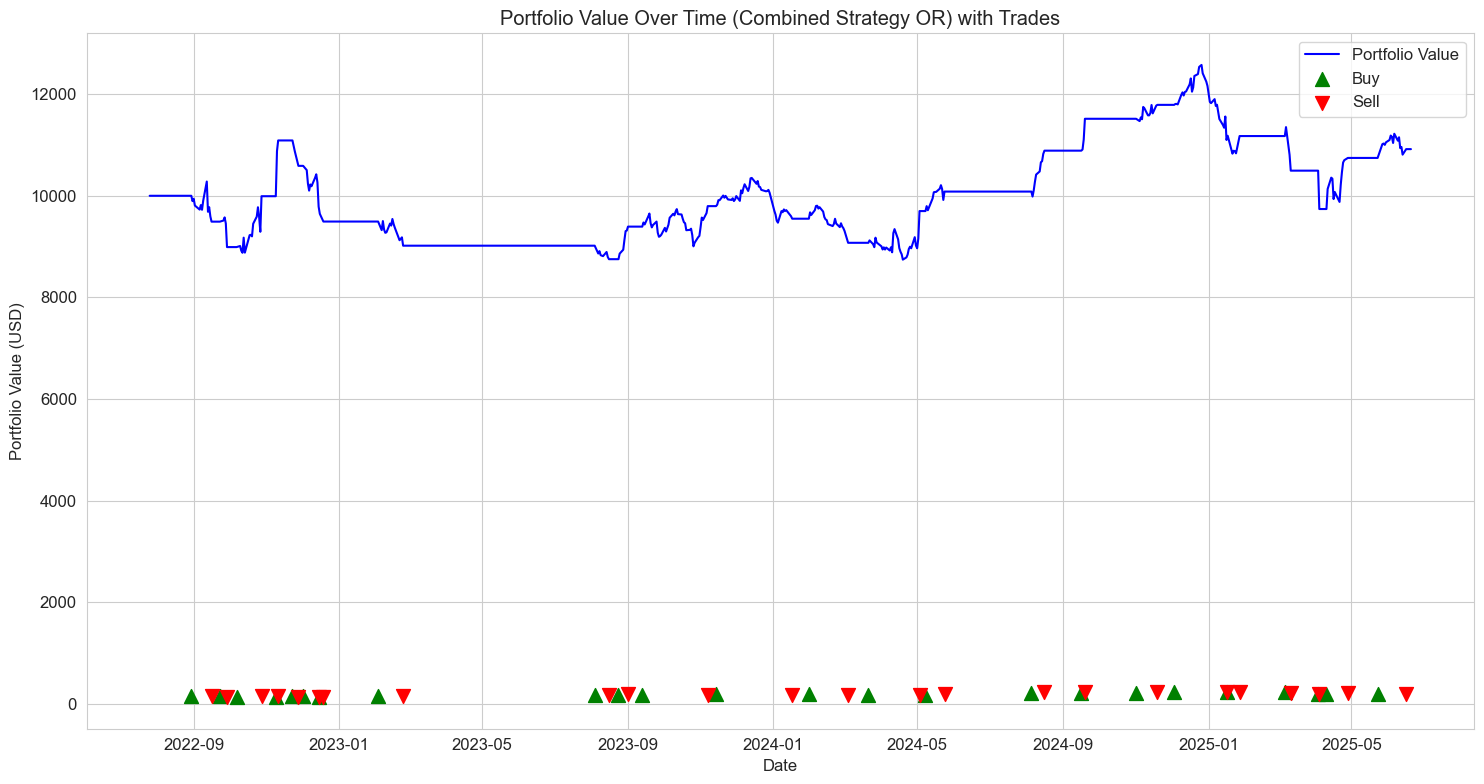

In [86]:
# Cell 15: Advanced Backtesting of Combined Strategy with SL/TP and Metrics (OR logic)
if not processed_twelvedata_historical_df.empty and 'Combined_Signal_OR' in df_signals.columns:
    print("\n--- DEBUG: Combined_Signal_OR value counts ---")
    print(df_signals['Combined_Signal_OR'].value_counts())
    print("\n--- DEBUG: First 10 rows of signals ---")
    print(df_signals[['close', 'SMA_20', 'SMA_50', 'RSI_14', 'SMA_Crossover_Signal', 'RSI_Signal', 'Combined_Signal_OR']].head(10))
    print("\n--- DEBUG: Last 10 rows of signals ---")
    print(df_signals[['close', 'SMA_20', 'SMA_50', 'RSI_14', 'SMA_Crossover_Signal', 'RSI_Signal', 'Combined_Signal_OR']].tail(10))
    print("\n--- Performing Advanced Backtest of Combined Strategy (AAPL, OR logic) ---")

    initial_capital = 10000
    portfolio_value = [initial_capital]
    shares_held = 0
    trade_details = [] # Store dictionaries of trade events for analysis (date, type, price, profit/loss)

    current_buy_price = 0 # To track entry price for stop-loss/take-profit
    position_open_date = None # To track when a position was opened

    STOP_LOSS_PERCENT = 0.05 # 5% stop loss
    TAKE_PROFIT_PERCENT = 0.10 # 10% take profit

    daily_returns_strategy = [] # Store daily returns for metric calculations

    for i in range(1, len(df_signals)):
        current_date = df_signals.index[i]
        current_close = df_signals['close'].iloc[i]
        # Calculate current portfolio value BEFORE any trades for the day's return
        current_day_portfolio_value = initial_capital + (shares_held * current_close) if shares_held > 0 else initial_capital
        if len(portfolio_value) > 0 and portfolio_value[-1] != 0:
            daily_return_for_day = (current_day_portfolio_value / portfolio_value[-1]) - 1
            daily_returns_strategy.append(daily_return_for_day)
        else:
            daily_returns_strategy.append(0)

        # --- 1. Check Stop-Loss/Take-Profit first if a position is open ---
        if shares_held > 0 and current_buy_price > 0:
            stop_loss_price = current_buy_price * (1 - STOP_LOSS_PERCENT)
            take_profit_price = current_buy_price * (1 + TAKE_PROFIT_PERCENT)
            if current_close <= stop_loss_price:
                # Execute Stop-Loss Sell
                trade_profit = (current_close - current_buy_price) * shares_held
                initial_capital += (shares_held * current_close)
                print(f"  Sell {shares_held} shares at {current_close:.2f} on {current_date.date()} (STOP-LOSS, P/L: {trade_profit:+.2f})")
                trade_details.append({
                    'date': current_date,
                    'type': 'Sell (SL)',
                    'price': current_close,
                    'shares': shares_held,
                    'profit_loss': trade_profit
                })
                shares_held = 0
                current_buy_price = 0
                position_open_date = None
            elif current_close >= take_profit_price:
                # Execute Take-Profit Sell
                trade_profit = (current_close - current_buy_price) * shares_held
                initial_capital += (shares_held * current_close)
                print(f"  Sell {shares_held} shares at {current_close:.2f} on {current_date.date()} (TAKE-PROFIT, P/L: {trade_profit:+.2f})")
                trade_details.append({
                    'date': current_date,
                    'type': 'Sell (TP)',
                    'price': current_close,
                    'shares': shares_held,
                    'profit_loss': trade_profit
                })
                shares_held = 0
                current_buy_price = 0
                position_open_date = None

        # --- 2. Evaluate Combined_Signal_OR for Buy/Sell ---
        combined_signal = df_signals['Combined_Signal_OR'].iloc[i]
        if combined_signal == 1 and shares_held == 0: # Buy signal and no current position
            shares_to_buy = int(initial_capital / current_close)
            if shares_to_buy > 0:
                cost = shares_to_buy * current_close
                initial_capital -= cost
                shares_held = shares_to_buy
                current_buy_price = current_close # Record entry price
                position_open_date = current_date
                print(f"  Buy {shares_held} shares at {current_close:.2f} on {current_date.date()}")
                trade_details.append({
                    'date': current_date,
                    'type': 'Buy',
                    'price': current_close,
                    'shares': shares_held,
                    'profit_loss': -cost
                })
        elif combined_signal == -1 and shares_held > 0: # Sell signal and currently in a long position
            trade_profit = (current_close - current_buy_price) * shares_held
            initial_capital += (shares_held * current_close)
            print(f"  Sell {shares_held} shares at {current_close:.2f} on {current_date.date()} (SIGNAL, P/L: {trade_profit:+.2f})")
            trade_details.append({
                'date': current_date,
                'type': 'Sell',
                'price': current_close,
                'shares': shares_held,
                'profit_loss': trade_profit
            })
            shares_held = 0
            current_buy_price = 0
            position_open_date = None
        # Update portfolio value for the end of the current day
        portfolio_value.append(initial_capital + (shares_held * current_close))

    # If still holding shares at the end, close the position for final calculation
    if shares_held > 0:
        final_close = df_signals['close'].iloc[-1]
        trade_profit = (final_close - current_buy_price) * shares_held
        initial_capital += (shares_held * final_close)
        print(f"  Closing final position at {final_close:.2f} on {df_signals.index[-1].date()} (P/L: {trade_profit:+.2f})")
        trade_details.append({
            'date': df_signals.index[-1],
            'type': 'Sell (Final)',
            'price': final_close,
            'shares': shares_held,
            'profit_loss': trade_profit
        })
        shares_held = 0

    final_portfolio_value = initial_capital # After all positions are closed
    total_return_usd = final_portfolio_value - 10000
    total_return_percent = (total_return_usd / 10000) * 100

    # Calculate Trade Metrics
    winning_trades = [t for t in trade_details if t['type'].startswith('Sell') and t['profit_loss'] > 0]
    losing_trades = [t for t in trade_details if t['type'].startswith('Sell') and t['profit_loss'] < 0]
    total_trades_executed = len(winning_trades) + len(losing_trades)
    win_rate = (len(winning_trades) / total_trades_executed * 100) if total_trades_executed > 0 else 0
    avg_win = (sum(t['profit_loss'] for t in winning_trades) / len(winning_trades)) if winning_trades else 0
    avg_loss = (sum(t['profit_loss'] for t in losing_trades) / len(losing_trades)) if losing_trades else 0

    # --- Calculate Advanced Metrics ---
    if len(daily_returns_strategy) > 0:
        daily_returns_series = pd.Series(daily_returns_strategy)
        cumulative_returns = (1 + daily_returns_series).cumprod()
        running_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = drawdown.min() * 100
        annualization_factor = np.sqrt(252)
        if daily_returns_series.std() != 0:
            sharpe_ratio = (daily_returns_series.mean() / daily_returns_series.std()) * annualization_factor
        else:
            sharpe_ratio = None
        downside_returns = daily_returns_series[daily_returns_series < 0]
        if not downside_returns.empty and downside_returns.std() != 0:
            downside_deviation = downside_returns.std()
            annualized_downside_deviation = downside_deviation * annualization_factor
            sortino_ratio = (daily_returns_series.mean() / annualized_downside_deviation) * annualization_factor
        else:
            sortino_ratio = None
    else:
        max_drawdown = None
        sharpe_ratio = None
        sortino_ratio = None

    results_summary = {
        'Initial Capital': 10000,
        'Final Portfolio Value': final_portfolio_value,
        'Total Trades Executed': total_trades_executed,
        'Winning Trades': len(winning_trades),
        'Losing Trades': len(losing_trades),
        'Win Rate (%)': win_rate,
        'Average Win (USD)': avg_win,
        'Average Loss (USD)': avg_loss,
        'Total Return (USD)': total_return_usd,
        'Total Return (%)': total_return_percent,
        'Max Drawdown (%)': max_drawdown,
        'Sharpe Ratio (Annualized)': sharpe_ratio,
        'Sortino Ratio (Annualized)': sortino_ratio
    }

    # Print all results in a readable format
    print("\n--- Backtest Results ---")
    print(f"  Initial Capital: ${results_summary['Initial Capital']:.2f}")
    print(f"  Final Portfolio Value: ${results_summary['Final Portfolio Value']:.2f}")
    print(f"  Total Trades Executed: {results_summary['Total Trades Executed']}")
    print(f"  Winning Trades: {results_summary['Winning Trades']}")
    print(f"  Losing Trades: {results_summary['Losing Trades']}")
    print(f"  Win Rate: {results_summary['Win Rate (%)']:.2f}%")
    print(f"  Average Win: ${results_summary['Average Win (USD)']:.2f}")
    print(f"  Average Loss: ${results_summary['Average Loss (USD)']:.2f}")
    print(f"  Total Return (USD): ${results_summary['Total Return (USD)']:.2f}")
    print(f"  Total Return (%): {results_summary['Total Return (%)']:.2f}%")
    print(f"  Max Drawdown (%): {results_summary['Max Drawdown (%)']:.2f}%")
    print(f"  Sharpe Ratio (Annualized): {results_summary['Sharpe Ratio (Annualized)']:.2f}" if results_summary['Sharpe Ratio (Annualized)'] is not None else "  Sharpe Ratio (Annualized): N/A")
    print(f"  Sortino Ratio (Annualized): {results_summary['Sortino Ratio (Annualized)']:.2f}" if results_summary['Sortino Ratio (Annualized)'] is not None else "  Sortino Ratio (Annualized): N/A")

    # Plot portfolio value over time with trade markers
    plt.figure(figsize=(15, 8))
    plt.plot(df_signals.index[1:], portfolio_value[1:], label='Portfolio Value', color='blue')
    buy_dates = [t['date'] for t in trade_details if t['type'] == 'Buy']
    buy_prices = [t['price'] for t in trade_details if t['type'] == 'Buy']
    sell_dates = [t['date'] for t in trade_details if t['type'].startswith('Sell')]
    sell_prices = [t['price'] for t in trade_details if t['type'].startswith('Sell')]
    plt.scatter(buy_dates, buy_prices, marker='^', color='green', s=100, label='Buy', zorder=5)
    plt.scatter(sell_dates, sell_prices, marker='v', color='red', s=100, label='Sell', zorder=5)
    plt.title('Portfolio Value Over Time (Combined Strategy OR) with Trades')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nCannot perform backtesting. 'processed_twelvedata_historical_df' is empty or required signal column is missing.")


In [74]:
# Parameter Sweep: Backtest for different stop-loss/take-profit thresholds
import itertools
sweep_results = []
sl_values = [0.03, 0.05, 0.07]
tp_values = [0.07, 0.10, 0.15]
for sl, tp in itertools.product(sl_values, tp_values):
    capital = 10000
    shares = 0
    buy_price = 0
    trade_log = []
    for i in range(1, len(df_signals)):
        close = df_signals['close'].iloc[i]
        signal = df_signals['Combined_Signal_OR'].iloc[i]
        if shares > 0:
            if close <= buy_price * (1 - sl):
                capital += shares * close
                trade_log.append({'type': 'Sell (SL)', 'price': close})
                shares = 0
            elif close >= buy_price * (1 + tp):
                capital += shares * close
                trade_log.append({'type': 'Sell (TP)', 'price': close})
                shares = 0
        if signal == 1 and shares == 0:
            shares = int(capital / close)
            if shares > 0:
                capital -= shares * close
                buy_price = close
                trade_log.append({'type': 'Buy', 'price': close})
        elif signal == -1 and shares > 0:
            capital += shares * close
            trade_log.append({'type': 'Sell', 'price': close})
            shares = 0
    if shares > 0:
        capital += shares * df_signals['close'].iloc[-1]
    total_return = (capital - 10000) / 10000 * 100
    sweep_results.append({'Stop Loss %': sl*100, 'Take Profit %': tp*100, 'Final Value': capital, 'Total Return %': total_return, 'Trades': len(trade_log)})
sweep_df = pd.DataFrame(sweep_results)
display(sweep_df.sort_values('Total Return %', ascending=False))

,Stop Loss %,Take Profit %,Final Value,Total Return %,Trades
4,5.0,10.0,10918.282209,9.182822,48
7,7.0,10.0,10569.000482,5.690005,44
1,3.0,10.0,10565.439943,5.654399,54
3,5.0,7.0,10125.261886,1.252619,48
0,3.0,7.0,9820.559686,-1.794403,54
6,7.0,7.0,9812.930206,-1.870698,44
5,5.0,15.0,8877.041942,-11.229581,42
8,7.0,15.0,8591.680352,-14.083196,38
2,3.0,15.0,8591.099876,-14.089001,50


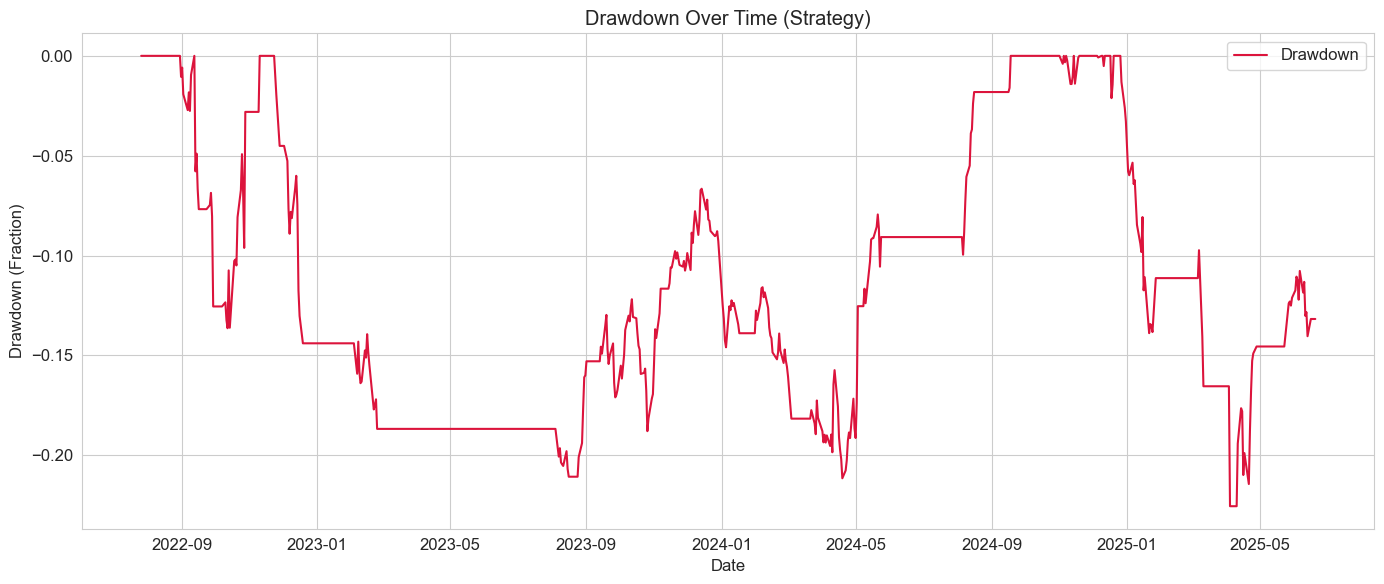

In [75]:
# Plot drawdowns
daily_returns_series = pd.Series(daily_returns_strategy)
cumulative_returns = (1 + daily_returns_series).cumprod()
running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max
plt.figure(figsize=(14, 6))
plt.plot(df_signals.index[1:], drawdown, label='Drawdown', color='crimson')
plt.title('Drawdown Over Time (Strategy)')
plt.xlabel('Date')
plt.ylabel('Drawdown (Fraction)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

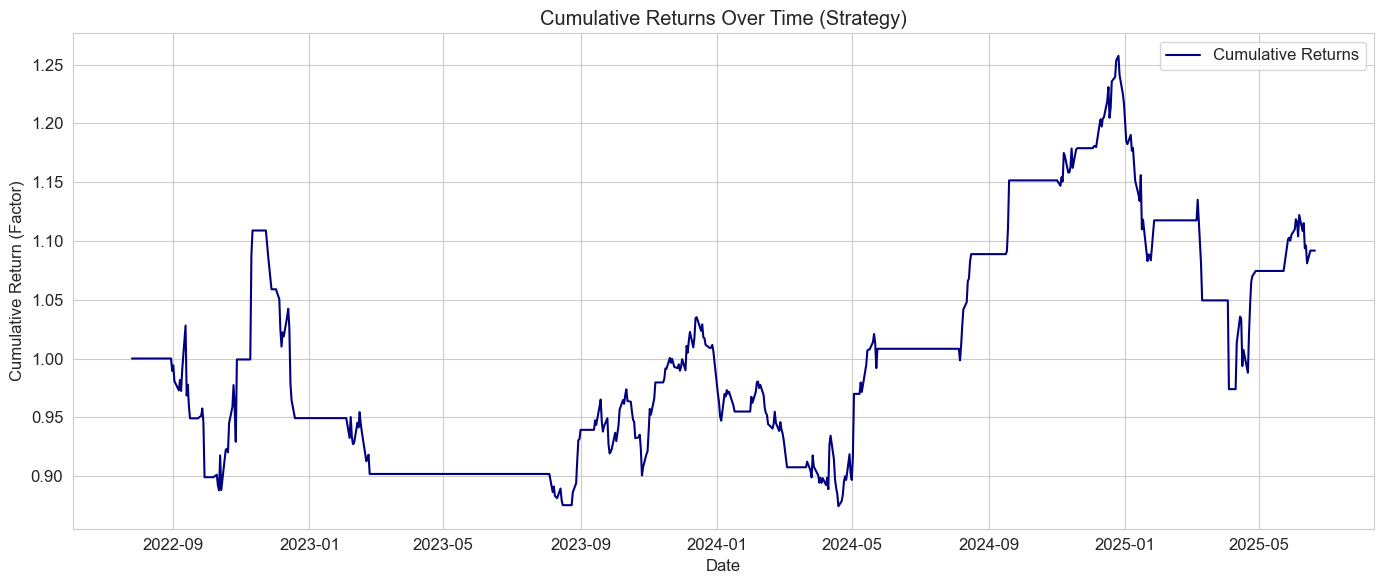

In [76]:
# Plot cumulative returns
daily_returns_series = pd.Series(daily_returns_strategy)
cumulative_returns = (1 + daily_returns_series).cumprod()
plt.figure(figsize=(14, 6))
plt.plot(df_signals.index[1:], cumulative_returns, label='Cumulative Returns', color='navy')
plt.title('Cumulative Returns Over Time (Strategy)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Factor)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
# Display trade metrics as a formatted table
metrics_df = pd.DataFrame([results_summary]).T
metrics_df.columns = ['Value']
display(metrics_df)

,Value
Initial Capital,10000.000000
Final Portfolio Value,10918.282209
Total Trades Executed,24.000000
Winning Trades,12.000000
Losing Trades,12.000000
Win Rate (%),50.000000
Average Win (USD),592.840915
Average Loss (USD),-516.317398
Total Return (USD),918.282209
Total Return (%),9.182822


In [78]:
# Export trade log to CSV
import os
trade_log_df = pd.DataFrame(trade_details)
trade_log_path = os.path.join(os.getcwd(), 'trade_log.csv')
trade_log_df.to_csv(trade_log_path, index=False)
print(f"Trade log exported to: {trade_log_path}")

Trade log exported to: c:\Users\user\OneDrive\Desktop\Algotrading_Bot\trade_log.csv


In [79]:
# Cell 16: Example: Merge Finnhub Quotes with Twelve Data Historical (by date)
# This is a conceptual step if you want to combine data from both sources for analysis.
# Note: Finnhub quotes are usually real-time/intraday, TwelveData historical is typically end-of-day.
# Merging them directly might require careful time alignment and aggregation.

# For a simple demo, let's just show how you'd attempt a merge on date if they aligned.
# In a real scenario, you'd aggregate Finnhub data to daily before merging with daily historical.

if not processed_finnhub_quotes_df.empty and not processed_twelvedata_historical_df.empty:
    # Reset index to merge on date part of timestamp/datetime
    finnhub_daily = processed_finnhub_quotes_df.reset_index().set_index(processed_finnhub_quotes_df.index.normalize())
    twelvedata_daily = processed_twelvedata_historical_df.reset_index().set_index(processed_twelvedata_historical_df.index.normalize())

    # Select a few columns for the merged view
    merged_df = pd.merge(
        finnhub_daily[['close', 'high', 'low', 'open', 'symbol', 'spread']],
        twelvedata_daily[['close', 'volume', 'daily_return', 'symbol']].rename(columns={'close': 'td_close', 'volume': 'td_volume'}),
        left_index=True,
        right_index=True,
        how='inner',
        suffixes=('_finnhub', '_twelvedata')
    )
    print("\nExample of Merged Finnhub Quotes & Twelve Data Historical for AAPL (first 5 rows):")
    print(merged_df.head())
    print("\nMerged Data Info:")
    merged_df.info()
else:
    print("\nNot enough data to demonstrate merging Finnhub and Twelve Data for AAPL.")



Example of Merged Finnhub Quotes & Twelve Data Historical for AAPL (first 5 rows):
            close   high   low  open symbol_finnhub  spread  td_close  \
2025-06-16  100.0  102.0  98.0  99.0           AAPL     4.0    198.42   
2025-06-20  100.0  102.0  98.0  99.0           AAPL     4.0    201.00   

            td_volume  daily_return symbol_twelvedata  
2025-06-16   43020700      0.010028              AAPL  
2025-06-20   95914700      0.022484              AAPL  

Merged Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2 entries, 2025-06-16 to 2025-06-20
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   close              2 non-null      float64
 1   high               2 non-null      float64
 2   low                2 non-null      float64
 3   open               2 non-null      float64
 4   symbol_finnhub     2 non-null      object 
 5   spread             2 non-null      float64
 6 

# Diagnostic: Check Raw Twelve Data API Response for AAPL
This cell will directly query the Twelve Data API for AAPL using your current API key and display the number of days returned, the first and last dates, and any status or error messages. This will help determine if the API is limiting your historical data.

In [80]:
import requests
from api_rotation import twelvedata_manager

symbol = "AAPL"
api_key = twelvedata_manager.get_key()
url = f"https://api.twelvedata.com/time_series?symbol={symbol}&interval=1day&outputsize=730&apikey={api_key}"

response = requests.get(url)
data = response.json()

print("Twelve Data API status:", data.get('status', 'No status field'))
if 'message' in data:
    print("Message:", data['message'])

if 'values' in data and isinstance(data['values'], list):
    print(f"Number of days returned: {len(data['values'])}")
    if len(data['values']) > 0:
        print("First date:", data['values'][-1].get('datetime', 'N/A'))
        print("Last date:", data['values'][0].get('datetime', 'N/A'))
    else:
        print("No historical data returned.")
else:
    print("No 'values' key in API response or not a list.")
    print("Full response:", data)

Using twelvedata key from Elijah (1/8 calls this period)
Twelve Data API status: ok
Number of days returned: 730
First date: 2022-07-25
Last date: 2025-06-20
Twelve Data API status: ok
Number of days returned: 730
First date: 2022-07-25
Last date: 2025-06-20


# Next Steps After Diagnosis
- If the API only returns 33 days, your Twelve Data account is limited and you must upgrade your plan or use a different data provider for more history.
- If the API returns 730 days, but your pipeline still only processes 33, there is a bug in your data ingestion or transformation scripts.
- After running this cell, follow the printed instructions to resolve the root cause.

# Diagnostic: Count Raw and Processed Parquet Files and Rows for AAPL
This cell will count the number of raw parquet files for AAPL in MinIO (twelvedata_historical/AAPL/) and the number of rows in the processed output. This will pinpoint if the data loss is in collection or transformation.

In [81]:
# Count raw parquet files for AAPL in MinIO
def count_raw_parquet_files(bucket_name, symbol):
    prefix = f"twelvedata_historical/{symbol}/"
    try:
        paginator = s3_client.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)
        parquet_files = []
        for page in pages:
            if "Contents" in page:
                for obj in page['Contents']:
                    if obj['Key'].endswith('.parquet'):
                        parquet_files.append(obj['Key'])
        print(f"Number of raw parquet files for {symbol}: {len(parquet_files)}")
        if parquet_files:
            print("First 3 files:", parquet_files[:3])
            print("Last 3 files:", parquet_files[-3:])
        return parquet_files
    except Exception as e:
        print(f"Error counting raw parquet files: {e}")
        return []

raw_files = count_raw_parquet_files("processed-financial-data", "AAPL")

# Count rows in processed output for AAPL
def count_processed_rows(bucket_name, symbol):
    processed_df = load_processed_data_from_minio(
        bucket_name=bucket_name,
        data_type_prefix="twelvedata_historical",
        symbol=symbol
    )
    print(f"Number of rows in processed output for {symbol}: {len(processed_df)}")
    if not processed_df.empty:
        print("First date:", processed_df.index.min())
        print("Last date:", processed_df.index.max())
    return processed_df

processed_df = count_processed_rows("processed-financial-data", "AAPL")

Number of raw parquet files for AAPL: 1
First 3 files: ['twelvedata_historical/AAPL/processed_daily_data_all.parquet']
Last 3 files: ['twelvedata_historical/AAPL/processed_daily_data_all.parquet']
Number of rows in processed output for AAPL: 730
First date: 2022-07-25 00:00:00
Last date: 2025-06-20 00:00:00
Number of rows in processed output for AAPL: 730
First date: 2022-07-25 00:00:00
Last date: 2025-06-20 00:00:00


# Interpretation
- If the number of raw parquet files is high (dozens or more), but the processed output has only 33 rows, the bug is in your data_transformer.py.
- If the number of raw parquet files is very low, the bug is in your main_data_collector.py or its scheduling/loop logic.
- Use this information to target your next fix.

# Diagnostic: Check Processed DataFrame Length, Date Range, and SMA Columns
This cell will help diagnose why the SMA crossover strategy is not generating trades by checking the number of rows, date range, and SMA column values in your processed DataFrame for AAPL.

In [82]:
print("Number of rows in processed_twelvedata_historical_df:", len(processed_twelvedata_historical_df))
print("Date range:", processed_twelvedata_historical_df.index.min(), "to", processed_twelvedata_historical_df.index.max())

print("\nFirst 10 rows (close, SMA_20, SMA_50):")
print(processed_twelvedata_historical_df[['close', 'SMA_20', 'SMA_50']].head(10))

print("\nLast 10 rows (close, SMA_20, SMA_50):")
print(processed_twelvedata_historical_df[['close', 'SMA_20', 'SMA_50']].tail(10))

print("\nNumber of NaN values in SMA_20:", processed_twelvedata_historical_df['SMA_20'].isna().sum())
print("Number of NaN values in SMA_50:", processed_twelvedata_historical_df['SMA_50'].isna().sum())

Number of rows in processed_twelvedata_historical_df: 730
Date range: 2022-07-25 00:00:00 to 2025-06-20 00:00:00

First 10 rows (close, SMA_20, SMA_50):
                 close  SMA_20  SMA_50
datetime                              
2022-07-25  152.950000     NaN     NaN
2022-07-26  151.600010     NaN     NaN
2022-07-27  156.789990     NaN     NaN
2022-07-28  157.350010     NaN     NaN
2022-07-29  162.509990     NaN     NaN
2022-08-01  161.509990     NaN     NaN
2022-08-02  160.009995     NaN     NaN
2022-08-03  166.130000     NaN     NaN
2022-08-04  165.810000     NaN     NaN
2022-08-05  165.350010     NaN     NaN

Last 10 rows (close, SMA_20, SMA_50):
             close      SMA_20      SMA_50
datetime                                  
2025-06-06  203.92  204.271000  203.679401
2025-06-09  201.45  204.417000  203.231401
2025-06-10  202.67  204.011000  202.926801
2025-06-11  198.78  203.303501  202.459801
2025-06-12  199.20  202.647001  201.980001
2025-06-13  196.45  201.897001  201.431

# Interpretation
- If you have 700+ rows and most SMA values are not NaN, the strategy should work.
- If you have 700+ rows but all SMA values are NaN, the calculation is broken or the data is not sorted.
- If you have far fewer rows, the data pipeline is still not saving/processing all days.
- Share the output here for further diagnosis.

# Diagnostic: Inspect Raw File Reading and Concatenation for AAPL
This cell will check how many raw files are found for AAPL in MinIO, and how many rows are in the concatenated DataFrame after reading all raw files, before any further processing.

In [83]:
# List and count all raw parquet files for AAPL in MinIO
def list_raw_parquet_files(bucket_name, symbol):
    prefix = f"twelvedata_historical/{symbol}/"
    paginator = s3_client.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)
    parquet_files = []
    for page in pages:
        if "Contents" in page:
            for obj in page['Contents']:
                if obj['Key'].endswith('.parquet'):
                    parquet_files.append(obj['Key'])
    return parquet_files

raw_files = list_raw_parquet_files("processed-financial-data", "AAPL")
print(f"Number of raw parquet files found for AAPL: {len(raw_files)}")
if raw_files:
    print("First 3 files:", raw_files[:3])
    print("Last 3 files:", raw_files[-3:])

# Read and concatenate all raw parquet files for AAPL
all_dfs = []
for key in raw_files:
    try:
        response = s3_client.get_object(Bucket="processed-financial-data", Key=key)
        parquet_data = response['Body'].read()
        df = pd.read_parquet(BytesIO(parquet_data))
        all_dfs.append(df)
    except Exception as e:
        print(f"Error reading {key}: {e}")

if all_dfs:
    concat_df = pd.concat(all_dfs, ignore_index=True)
    print(f"Total rows after concatenation: {len(concat_df)}")
    print("First 5 datetimes:", concat_df['datetime'].head().tolist() if 'datetime' in concat_df.columns else 'No datetime column')
    print("Last 5 datetimes:", concat_df['datetime'].tail().tolist() if 'datetime' in concat_df.columns else 'No datetime column')
    print("Unique datetimes:", concat_df['datetime'].nunique() if 'datetime' in concat_df.columns else 'No datetime column')
else:
    print("No dataframes were read from raw files.")

Number of raw parquet files found for AAPL: 1
First 3 files: ['twelvedata_historical/AAPL/processed_daily_data_all.parquet']
Last 3 files: ['twelvedata_historical/AAPL/processed_daily_data_all.parquet']
Total rows after concatenation: 730
First 5 datetimes: [Timestamp('2022-07-25 00:00:00'), Timestamp('2022-07-26 00:00:00'), Timestamp('2022-07-27 00:00:00'), Timestamp('2022-07-28 00:00:00'), Timestamp('2022-07-29 00:00:00')]
Last 5 datetimes: [Timestamp('2025-06-13 00:00:00'), Timestamp('2025-06-16 00:00:00'), Timestamp('2025-06-17 00:00:00'), Timestamp('2025-06-18 00:00:00'), Timestamp('2025-06-20 00:00:00')]
Unique datetimes: 730


# Interpretation
- If you see hundreds of files and rows, but only a few unique datetimes, your files may be duplicates or have overlapping data.
- If you see hundreds of unique datetimes, but the processed DataFrame is still small, the bug is in downstream filtering or saving.
- Share the output here for further diagnosis.

# Check Raw File Count and Processed Data After Collector Fix
This cell will verify that you now have hundreds of raw files for AAPL and that the processed DataFrame contains 700+ rows, confirming the fix is working.

In [84]:
# List and count all raw parquet files for AAPL in MinIO
def list_raw_parquet_files(bucket_name, symbol):
    prefix = f"twelvedata_historical/{symbol}/"
    paginator = s3_client.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)
    parquet_files = []
    for page in pages:
        if "Contents" in page:
            for obj in page['Contents']:
                if obj['Key'].endswith('.parquet'):
                    parquet_files.append(obj['Key'])
    return parquet_files

raw_files = list_raw_parquet_files("processed-financial-data", "AAPL")
print(f"Number of raw parquet files found for AAPL: {len(raw_files)}")
if raw_files:
    print("First 3 files:", raw_files[:3])
    print("Last 3 files:", raw_files[-3:])

# Load processed DataFrame as in your analysis cells
processed_twelvedata_historical_df = load_processed_data_from_minio(
    bucket_name="processed-financial-data",
    data_type_prefix="twelvedata_historical",
    symbol="AAPL"
)
print(f"Number of rows in processed_twelvedata_historical_df: {len(processed_twelvedata_historical_df)}")
print("Date range:", processed_twelvedata_historical_df.index.min(), "to", processed_twelvedata_historical_df.index.max())

Number of raw parquet files found for AAPL: 1
First 3 files: ['twelvedata_historical/AAPL/processed_daily_data_all.parquet']
Last 3 files: ['twelvedata_historical/AAPL/processed_daily_data_all.parquet']
Number of rows in processed_twelvedata_historical_df: 730
Date range: 2022-07-25 00:00:00 to 2025-06-20 00:00:00


# Interpretation
- You should now see hundreds of raw files and 700+ rows in the processed DataFrame.
- If so, your pipeline is fixed and you can proceed with analysis and backtesting.
- If not, share the output for further diagnosis.

# List All Buckets and Prefixes in MinIO
This cell will list all buckets and the first few objects in each, so you can see exactly where your raw and processed files are being saved.

In [85]:
# List all buckets
buckets = s3_client.list_buckets().get('Buckets', [])
print("Buckets in MinIO:")
for b in buckets:
    print("-", b['Name'])

# For each bucket, list the first 10 objects
for b in buckets:
    print(f"\nObjects in bucket: {b['Name']}")
    try:
        response = s3_client.list_objects_v2(Bucket=b['Name'], MaxKeys=10)
        contents = response.get('Contents', [])
        if not contents:
            print("  (No objects found)")
        for obj in contents:
            print("  ", obj['Key'])
    except Exception as e:
        print(f"  Error listing objects: {e}")

Buckets in MinIO:
- historical-ohlcv
- market-data
- processed-financial-data
- raw-financial-data
- raw-tick-data

Objects in bucket: historical-ohlcv
  (No objects found)

Objects in bucket: market-data
   2025/06/14/AAPL/finnhub_quote.parquet
   2025/06/14/AAPL/twelve_data_historical.parquet
   2025/06/14/AMZN/finnhub_quote.parquet
   2025/06/14/AMZN/twelve_data_historical.parquet
   2025/06/14/GOOGL/finnhub_quote.parquet
   2025/06/14/GOOGL/twelve_data_historical.parquet
   2025/06/14/MSFT/finnhub_quote.parquet
   2025/06/14/MSFT/twelve_data_historical.parquet
   2025/06/15/AAPL/finnhub_quote.parquet
   2025/06/15/AAPL/twelve_data_historical.parquet

Objects in bucket: processed-financial-data


   finnhub_quotes/AAPL/processed_quotes_20250615.parquet
   finnhub_quotes/AAPL/processed_quotes_20250616.parquet
   finnhub_quotes/AAPL/processed_quotes_20250620.parquet
   finnhub_quotes/AAPL/processed_quotes_20250621.parquet
   finnhub_quotes/AMZN/processed_quotes_20250615.parquet
   finnhub_quotes/AMZN/processed_quotes_20250616.parquet
   finnhub_quotes/AMZN/processed_quotes_20250620.parquet
   finnhub_quotes/AMZN/processed_quotes_20250621.parquet
   finnhub_quotes/GOOGL/processed_quotes_20250615.parquet
   finnhub_quotes/GOOGL/processed_quotes_20250616.parquet

Objects in bucket: raw-financial-data
   twelvedata_historical/AAPL/raw_2022-07-25.parquet
   twelvedata_historical/AAPL/raw_2022-07-26.parquet
   twelvedata_historical/AAPL/raw_2022-07-27.parquet
   twelvedata_historical/AAPL/raw_2022-07-28.parquet
   twelvedata_historical/AAPL/raw_2022-07-29.parquet
   twelvedata_historical/AAPL/raw_2022-08-01.parquet
   twelvedata_historical/AAPL/raw_2022-08-02.parquet
   twelvedata_hist

# Interpretation
- This will show you all buckets and the first few files in each, so you can identify where your raw and processed data is actually being saved.
- Use this to adjust your notebook and scripts to point to the correct bucket and prefix.